In [1]:
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
from pathlib import Path
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import copy
from io import BytesIO
from urllib import request

from sklearn.preprocessing import MinMaxScaler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
np.random.seed(42)

In [2]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [3]:
class HouseDataset(Dataset):
    def __init__(self, image_paths, targets, transforms=None):
        super().__init__()
        self.image_paths = image_paths
        self.targets = targets
        self.transforms = transforms
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        price = self.targets[index]
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        height, width = image.shape[:-1]
        if self.transforms:
            image = self.transforms(image=image)['image']
        else:
            image = torch.tensor(image, dtype=torch.float32)
        price = torch.tensor(price, dtype=torch.float32)
        return image, price
    def __len__(self):
        return len(self.image_paths)

In [4]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
        A.RGBShift(r_shift_limit=0.05, g_shift_limit=0.05, b_shift_limit=0.05, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [5]:
def visualize(dataset, idx=0):
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([t for t in dataset.transforms if not isinstance(t, (ToTensorV2, A.Normalize))])
    figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    axes = ax.ravel()
    for i in range(6):
        image, target = dataset[i]
        axes[i].imshow(image)
        axes[i].set_title(f"price: {target}")
        axes[i].set_axis_off()
    plt.tight_layout()
    figure.savefig('sample.jpg')

def data_prep(imagepath, target):
    zipped = list(zip(imagepath, targets))
    n = int(0.7 * len(zipped))
    path_img, path_targets = zip(*np.random.permutation(zipped))

    train_img, val_img = np.array(list(path_img[:n])), np.array(list(path_img[n:]))
    train_targets, val_targets = np.array(list(path_targets[:n])), np.array(list(path_targets[n:]))

    scaler = MinMaxScaler()
    train_targets = scaler.fit_transform(train_targets.reshape(-1,1)).reshape(-1)
    val_targets = scaler.transform(val_targets.reshape(-1,1)).reshape(-1)

    # train_img, val_img = list(path_img[:n]), list(path_img[n:])
    # train_targets, val_targets = list(path_targets[:n]), list(path_targets[n:])
    
    train_dataset = HouseDataset(train_img, train_targets, train_transform)
    val_dataset = HouseDataset(val_img, val_targets, val_transform)
    len(train_dataset), len(val_dataset)
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        pin_memory=True,
    )
    return (train_loader, val_loader, train_dataset,
            val_dataset, train_targets, val_targets, scaler)


In [6]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler,scaler, num_epochs=25):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        closs = 0
        for batch_idx, (image, price) in enumerate(train_dataloader):
            optimizer.zero_grad()
            image, price = image.to(device), price.to(device)
            output = model(image).view(-1)
            loss = criterion(output, price)
            #print("loss: ", loss.item())
            # print("output: ", output)
            # print("price: ", price)
            closs += loss.item()
            loss.backward()
            optimizer.step()
            #wandb.log({'batch train': batch_idx, 'batch loss: ':loss.item()})
        print(f"End of epoch {epoch}. Loss {closs/len(train_loader)}")
        #wandb.log({'epoch': epoch,'Loss epoch: ': closs/len(train_loader)})
        
        scheduler.step()
        cmae = 0
        model.eval()
        for batch_idx, (image, price) in enumerate(val_dataloader):
            image, price = image.to(device), price
            output = model(image)
            output = torch.tensor(scaler.inverse_transform(output.cpu().detach().numpy()), dtype=torch.float32)
            price = torch.tensor(scaler.inverse_transform(price.numpy().reshape(-1, 1)), dtype=torch.float32)
            
            # print("output ", output)
            # print("price ", price)
            mae = metric(output, price)
            #print(mae.item)
            cmae += mae.item()
            #wandb.log({'batch eval': batch_idx, 'batch MAE metric: ': mae.item()})
        print(f"MAE {cmae/len(val_dataloader)}")
       # wandb.log({'epoch': epoch, 'MAE epoch: ' : cmae/len(val_dataloader)})

In [7]:
house_info_string = glob.glob(r"../input/house-price/Houses Dataset/*.txt")[0]
with open(house_info_string, 'r') as f:
    info = f.readlines()

# Turn metadata to Dataframe
new_info = [i.split(' ') for i in info]
bedroom = [int(i[0]) for i in new_info]
bathroom = [float(i[1]) for i in new_info]
area = [float(i[2]) for i in new_info]
zipcode = [int(i[3]) for i in new_info]
price = [int(i[4].strip()) for i in new_info]

dict = {'bedroom': bedroom, 'bathroom':bathroom, 
        'area':area, 'zipcode':zipcode, 'price':price}
metadata = pd.DataFrame(dict)


In [8]:
houses_frontal = glob.glob(r"../input/house-price/Houses Dataset/*frontal.jpg")
houses_bedroom = glob.glob(r"../input/house-price/Houses Dataset/*bedroom.jpg")
houses_bathroom = glob.glob(r"../input/house-price/Houses Dataset/*bathroom.jpg")
houses_kitchen = glob.glob(r"../input/house-price/Houses Dataset/*kitchen.jpg")

houses_frontal.sort(key=natural_keys)
houses_bedroom.sort(key=natural_keys)
houses_bathroom.sort(key=natural_keys)
houses_kitchen.sort(key=natural_keys)

targets = metadata['price'].to_numpy()

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet50(pretrained=True)
in_f = model.fc.in_features
model.fc = torch.nn.Sequential(torch.nn.Linear(in_f, 1), torch.nn.Sigmoid())
# model.fc = torch.nn.Linear(in_f, 1)

criterion = torch.nn.MSELoss()
metric = torch.nn.L1Loss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
(train_loader, val_loader, train_dataset,
        val_dataset, train_target, val_target, scaler) = data_prep(houses_bedroom, targets)

for x in train_dataset:
    print(x[0].shape)
    break
train_model(model, train_loader, val_loader, criterion, 
            optimizer_ft, exp_lr_scheduler,scaler, num_epochs=25)

torch.Size([3, 224, 224])
End of epoch 0. Loss 0.058944240833322205
MAE 501711.1436737805
End of epoch 1. Loss 0.011219841544516385
MAE 504272.3978658537
End of epoch 2. Loss 0.01388914188525329
MAE 512393.1787347561
End of epoch 3. Loss 0.013202420979117354
MAE 477130.8711890244
End of epoch 4. Loss 0.012755965037892262
MAE 449564.1532012195
End of epoch 5. Loss 0.012165274897900721
MAE 424874.9226371951
End of epoch 6. Loss 0.011310380844709774
MAE 384712.384527439
End of epoch 7. Loss 0.010703003848902881
MAE 387914.96341463417
End of epoch 8. Loss 0.011830499259910235
MAE 384812.24771341466
End of epoch 9. Loss 0.010722897636393705
MAE 377057.3788109756
End of epoch 10. Loss 0.010450159199535847
MAE 393619.1320503049
End of epoch 11. Loss 0.010352746796949456
MAE 385965.8666158537
End of epoch 12. Loss 0.010482445436840257
MAE 369648.796875
End of epoch 13. Loss 0.010543761542066932
MAE 372547.74009146343
End of epoch 14. Loss 0.010212183134475103
MAE 367953.87842987804
End of epoc

In [11]:
# model2 = torchvision.models.resnet50(pretrained=True)
# in_f = model2.fc.in_features
# model2.fc = torch.nn.Sequential(torch.nn.Linear(in_f, 1), torch.nn.Sigmoid())
# criterion = torch.nn.MSELoss()
# metric = torch.nn.L1Loss()
# optimizer_ft = torch.optim.SGD(model2.parameters(), lr=0.0001, momentum=0.9)
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# (train_loader, val_loader, train_dataset,
#         val_dataset, train_target, val_target, scaler) = data_prep(houses_bathroom, targets)

# train_model(model2, train_loader, val_loader, criterion, 
#             optimizer_ft, exp_lr_scheduler,scaler, num_epochs=25)

In [12]:
# (train_loader, val_loader, train_dataset,
#         val_dataset, train_target, val_target, scaler) = data_prep(houses_frontal, targets)

# for x in train_dataset:
#     print(x[0].shape)
#     break
# train_model(model, train_loader, val_loader, criterion, 
#             optimizer_ft, exp_lr_scheduler,scaler, num_epochs=25)

Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


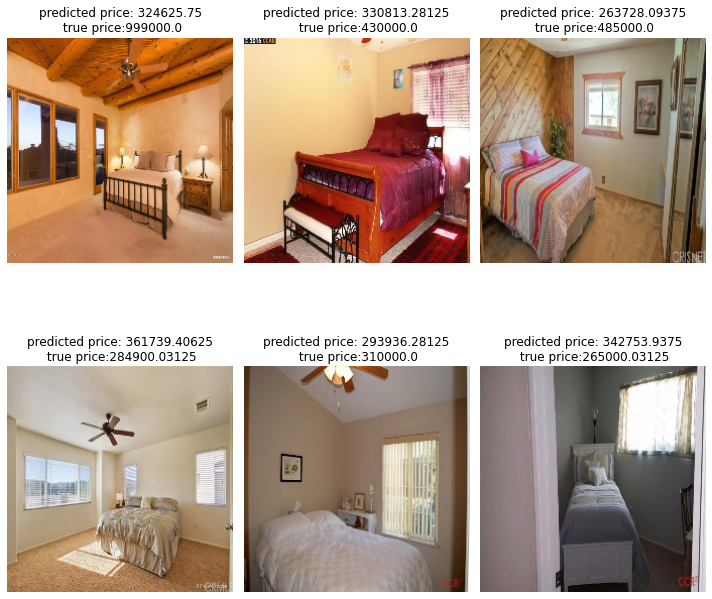

In [13]:
def check(model, dataset, scaler):
    model.eval()
    dataset_tomodel = copy.deepcopy(dataset)
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([t for t in dataset.transforms if not isinstance(t, (ToTensorV2, A.Normalize))])
    print(dataset.transforms)
    figure, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
    axes = ax.ravel()
    for i, n in zip(range(6),np.random.randint(len(dataset), size=6)):
        image, target = dataset_tomodel[n]
        print(image.shape)
        image = image.to(device)
        output = model(image.unsqueeze(0)).view(-1)
        output = scaler.inverse_transform(output.cpu().detach().numpy().reshape(1, -1))
        image, target = dataset[n]
        target = scaler.inverse_transform(target.cpu().detach().numpy().reshape(1, -1))
        axes[i].imshow(image)
        axes[i].set_title(f"predicted price: {output[0][0]}\n true price:{target[0][0]}")
        axes[i].set_axis_off()
    plt.tight_layout()

    # figure.savefig('sample.jpg')
    
check(model, val_dataset, scaler)

In [14]:
val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img

def prepare_image(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

def datapreparation(image, transforms = None):

    #image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = np.array(image).astype('float32')
    image /= 255.0
    height, width = image.shape[:-1]
    if transforms:
        image = transforms(image=image)['image']
        image = torch.tensor(image, dtype = torch.float32)
    else:
        image = torch.tensor(image, dtype=torch.float32)
    return image


def prediction(model, image_url, scaler):
    
    model.eval()
    image = download_image(image_url)
    image = prepare_image(image)
    image = datapreparation(image,transforms = val_transform).to(device)
    image = image.to(device)
    output = model(image.unsqueeze(0)).view(-1)
    output = scaler.inverse_transform(output.cpu().detach().numpy().reshape(1, -1))[0][0]
    return output

In [15]:
import pickle
torch.save(model, 'model.pth')
with open('scalel.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [16]:
model_path = '/kaggle/working/model.pth'
scaler_path = '/kaggle/working/scalel.pkl'
def load_utils(model_path, scaler_path):
    
    model = torch.load(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    return model, scaler

model, scaler = load_utils(model_path, scaler_path)
part1 = 'https://plus.unsplash.com/premium_photo-1674574586052-6d0cee95c473?ixlib=rb-4.'
part2 = '0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1129&q=80'

image_url = part1 + part2
prediction(model, image_url, scaler)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


335397.4